In [186]:
# Main function to analyze stocks
def analyze_stocks():
    decision_results = {}
    sp500_tickers = get_sp500_tickers()  # Fetch the full list of S&P 500 tickers
    
    for stock in sp500_tickers:
        try:
            # Fetch stock data and dynamic start date
            data, start_date = fetch_data(stock)
            
            # Calculate moving averages and crossovers
            data = calculate_moving_averages(data)
            
            # Generate buy/sell/hold signals
            data = generate_signals(data)
            
            # Calculate performance (profits, wealth)
            data = evaluate_performance(data)

            # Get latest signals and wealth
            latest_short_term_signal = data['Short-Term Signal'].iloc[-1]  # Latest short-term signal
            latest_long_term_signal = data['Long-Term Signal'].iloc[-1]  # Latest long-term signal
            latest_wealth = data['Wealth'].iloc[-1]  # Latest wealth from the strategy

            # Add current price (latest close price) and average trading volume
            current_price = data['Close'].iloc[-1]
            average_volume = data['Volume'].mean()

            # Calculate confidence levels for short-term and long-term signals
            if latest_short_term_signal == 'Buy' and latest_long_term_signal == 'Buy':
                short_term_confidence = 1.0  # Strongest Buy signal
                long_term_confidence = 1.0
            elif latest_short_term_signal == 'Sell' and latest_long_term_signal == 'Sell':
                short_term_confidence = -1.0  # Strongest Sell signal
                long_term_confidence = -1.0
            else:
                short_term_confidence = 0.5  # Neutral/hold signal
                long_term_confidence = 0.5

            # Collect data for output
            decision_results[stock] = {
                'Stock Name': stock,
                'Current Price': current_price,
                'Average Volume': average_volume,
                'MA5': data['MA5'].iloc[-1],  # Latest MA5
                'MA10': data['MA10'].iloc[-1],  # Latest MA10
                'MA50': data['MA50'].iloc[-1],  # Latest MA50
                'MA200': data['MA200'].iloc[-1],  # Latest MA200
                'Short-Term Signal': latest_short_term_signal,
                'Long-Term Signal': latest_long_term_signal,
                'Short-Term Confidence': short_term_confidence,
                'Long-Term Confidence': long_term_confidence,
                'Wealth': latest_wealth,
                'Start Date': start_date  # Include start date for reference
            }
        except ValueError as e:
            # Handle missing data for stock (i.e., no data available)
            print(f"Skipping {stock}: {e}")
        except Exception as e:
            print(f"Error processing {stock}: {e}")
    
    # Rank the results by confidence level (highest confidence first)
    decision_results = dict(sorted(decision_results.items(), key=lambda item: item[1]['Short-Term Confidence'], reverse=True))

    return decision_results

In [187]:
# Example usage
results = analyze_stocks()

Error processing AMTM: single positional indexer is out-of-bounds



1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Skipping BRK.B: No data found for BRK.B



1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-12-11 -> 2024-11-16)')


Skipping BF.B: No data found for BF.B
Error processing GEV: single positional indexer is out-of-bounds
Error processing SW: single positional indexer is out-of-bounds
Error processing SOLV: single positional indexer is out-of-bounds


In [183]:
# Print the results in descending order of short-term confidence level
for stock, result in results.items():
    print(f"{stock}:")
    # Ensure we're getting the scalar value from the Series for 'Current Price'
    current_price = result['Current Price'] if isinstance(result['Current Price'], (int, float)) else result['Current Price'].iloc[0]
    print(f"  Current Price: ${current_price:.2f}")
    
    print(f"  Average Volume: {result['Average Volume']}")
    print(f"  MA5: {result['MA5']:.2f}")
    print(f"  MA10: {result['MA10']:.2f}")
    print(f"  MA50: {result['MA50']:.2f}")
    print(f"  MA200: {result['MA200']:.2f}")
    print(f"  Short-Term Signal: {result['Short-Term Signal']}")
    print(f"  Long-Term Signal: {result['Long-Term Signal']}")
    print(f"  Short-Term Confidence: {result['Short-Term Confidence']:.2f}")
    print(f"  Long-Term Confidence: {result['Long-Term Confidence']:.2f}")
    print(f"  Wealth: ${result['Wealth']:.2f}")
    print(f"  Start Date: {result['Start Date']}\n")


MMM:
  Current Price: $132.32
  Average Volume: Ticker
MMM    2.427076e+06
dtype: float64
  MA5: 132.29
  MA10: 130.80
  MA50: 132.78
  MA200: 107.86
  Short-Term Signal: Buy
  Long-Term Signal: Buy
  Short-Term Confidence: 1.00
  Long-Term Confidence: 1.00
  Wealth: $-15.97
  Start Date: 1962-01-02

ACN:
  Current Price: $362.07
  Average Volume: Ticker
ACN    2.909100e+06
dtype: float64
  MA5: 361.15
  MA10: 355.76
  MA50: 355.26
  MA200: 335.04
  Short-Term Signal: Buy
  Long-Term Signal: Buy
  Short-Term Confidence: 1.00
  Long-Term Confidence: 1.00
  Wealth: $280.23
  Start Date: 2001-07-19

AFL:
  Current Price: $109.68
  Average Volume: Ticker
AFL    3.590080e+06
dtype: float64
  MA5: 109.89
  MA10: 108.03
  MA50: 110.36
  MA200: 94.14
  Short-Term Signal: Buy
  Long-Term Signal: Buy
  Short-Term Confidence: 1.00
  Long-Term Confidence: 1.00
  Wealth: $39.18
  Start Date: 1980-03-17

APD:
  Current Price: $315.88
  Average Volume: Ticker
APD    1.009918e+06
dtype: float64
  MA5:

In [188]:
import pandas as pd
import yfinance as yf
import numpy as np

# Function to fetch the earliest available date for a stock
def fetch_data(ticker):
    # Use yfinance to get historical data for the stock
    data = yf.download(ticker, period="max", progress=False)  # Get the max period (all available data)
    
    # Check if data is empty
    if data.empty:
        raise ValueError(f"No data found for {ticker}")

    # Get the first date in the dataset
    start_date = data.index.min()
    
    # Convert to string for formatting consistency
    start_date_str = start_date.strftime('%Y-%m-%d')
    
    return data, start_date_str

# Function to calculate short-term and long-term moving averages
def calculate_moving_averages(data):
    # Short-term moving averages
    data['MA5'] = data['Close'].rolling(5).mean()  # Short-term fast signal
    data['MA10'] = data['Close'].rolling(10).mean()  # Short-term signal
    
    # Long-term moving averages
    data['MA50'] = data['Close'].rolling(50).mean()  # Medium-term signal
    data['MA200'] = data['Close'].rolling(200).mean()  # Long-term signal
    
    # Crossover signals
    data['Short-Term Crossover'] = np.where(data['MA5'] > data['MA10'], 1, 0)
    data['Long-Term Crossover'] = np.where(data['MA50'] > data['MA200'], 1, 0)
    
    data.dropna(inplace=True)
    return data

# Function to generate signals for both short-term and long-term
def generate_signals(data):
    data['Short-Term Signal'] = np.where(data['Short-Term Crossover'] == 1, 'Buy', 'Hold')
    data['Long-Term Signal'] = np.where(data['Long-Term Crossover'] == 1, 'Buy', 'Hold')
    
    # Sell signal for the opposite crossover condition
    data['Short-Term Signal'] = np.where(data['Short-Term Crossover'] == 0, 'Sell', data['Short-Term Signal'])
    data['Long-Term Signal'] = np.where(data['Long-Term Crossover'] == 0, 'Sell', data['Long-Term Signal'])
    
    return data

def evaluate_performance(data):
    # Ensure a copy of the data to avoid setting on a view
    data = data.copy()

    # Access 'Close' column for the stock of interest (e.g., 'AAPL')
    ticker = data.columns.get_level_values(1)[0]  # Assuming we are analyzing one stock at a time

    # Shift close prices to get next day's price
    data.loc[:, ('Close1', ticker)] = data[('Close', ticker)].shift(-1)

    # Drop the last row because it contains NaN in 'Close1'
    data = data.dropna(subset=[('Close1', ticker)])

    # Calculate Profit where Buy signal (Short-Term Crossover = 1)
    data.loc[:, 'Profit'] = np.where(data[('Short-Term Crossover', '')] == 1, 
                                     data[('Close1', ticker)] - data[('Close', ticker)], 0)

    # Calculate Wealth as the cumulative sum of the profits
    data.loc[:, 'Wealth'] = data['Profit'].cumsum()

    return data

# Function to fetch S&P 500 tickers using Wikipedia scraping
def get_sp500_tickers():
    # URL of the Wikipedia page with the list of S&P 500 companies
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Use pandas to scrape the table from the page
    tables = pd.read_html(url)
    
    # The table we're interested in is the first one, which contains the S&P 500 companies
    sp500_table = tables[0]
    
    # Extract the 'Symbol' column
    sp500_tickers = sp500_table['Symbol'].tolist()
    
    return sp500_tickers

# Main function to analyze stocks
def analyze_stocks():
    decision_results = {}
    sp500_tickers = get_sp500_tickers()  # Fetch the full list of S&P 500 tickers
    
    for stock in sp500_tickers:
        try:
            # Fetch stock data and dynamic start date
            data, start_date = fetch_data(stock)
            
            # Calculate moving averages and crossovers
            data = calculate_moving_averages(data)
            
            # Generate buy/sell/hold signals
            data = generate_signals(data)
            
            # Calculate performance (profits, wealth)
            data = evaluate_performance(data)

            # Get latest signals and wealth
            latest_short_term_signal = data['Short-Term Signal'].iloc[-1]  # Latest short-term signal
            latest_long_term_signal = data['Long-Term Signal'].iloc[-1]  # Latest long-term signal
            latest_wealth = data['Wealth'].iloc[-1]  # Latest wealth from the strategy

            # Add current price (latest close price) and average trading volume
            current_price = data['Close'].iloc[-1]
            average_volume = data['Volume'].mean()

            # Calculate confidence levels for short-term and long-term signals
            if latest_short_term_signal == 'Buy' and latest_long_term_signal == 'Buy':
                short_term_confidence = 1.0  # Strongest Buy signal
                long_term_confidence = 1.0
            elif latest_short_term_signal == 'Sell' and latest_long_term_signal == 'Sell':
                short_term_confidence = -1.0  # Strongest Sell signal
                long_term_confidence = -1.0
            else:
                short_term_confidence = 0.5  # Neutral/hold signal
                long_term_confidence = 0.5

            # Collect data for output
            decision_results[stock] = {
                'Stock Name': stock,
                'Current Price': current_price,
                'Average Volume': average_volume,
                'MA5': data['MA5'].iloc[-1],  # Latest MA5
                'MA10': data['MA10'].iloc[-1],  # Latest MA10
                'MA50': data['MA50'].iloc[-1],  # Latest MA50
                'MA200': data['MA200'].iloc[-1],  # Latest MA200
                'Short-Term Signal': latest_short_term_signal,
                'Long-Term Signal': latest_long_term_signal,
                'Short-Term Confidence': short_term_confidence,
                'Long-Term Confidence': long_term_confidence,
                'Wealth': latest_wealth,
                'Start Date': start_date  # Include start date for reference
            }
        except ValueError as e:
            # Handle missing data for stock (i.e., no data available)
            print(f"Skipping {stock}: {e}")
        except Exception as e:
            print(f"Error processing {stock}: {e}")
    
    # Rank the results by confidence level (highest confidence first)
    decision_results = dict(sorted(decision_results.items(), key=lambda item: item[1]['Short-Term Confidence'], reverse=True))

    return decision_results

# Example usage
results = analyze_stocks()

# Print the results in descending order of short-term confidence level
for stock, result in results.items():
    print(f"{stock}:")
    # Ensure we're getting the scalar value from the Series for 'Current Price'
    current_price = result['Current Price'] if isinstance(result['Current Price'], (int, float)) else result['Current Price'].iloc[0]
    print(f"  Current Price: ${current_price:.2f}")
    
    print(f"  Average Volume: {result['Average Volume']}")
    print(f"  MA5: {result['MA5']:.2f}")
    print(f"  MA10: {result['MA10']:.2f}")
    print(f"  MA50: {result['MA50']:.2f}")
    print(f"  MA200: {result['MA200']:.2f}")
    print(f"  Short-Term Signal: {result['Short-Term Signal']}")
    print(f"  Long-Term Signal: {result['Long-Term Signal']}")
    print(f"  Short-Term Confidence: {result['Short-Term Confidence']:.2f}")
    print(f"  Long-Term Confidence: {result['Long-Term Confidence']:.2f}")
    print(f"  Wealth: ${result['Wealth']:.2f}")
    print(f"  Start Date: {result['Start Date']}\n")

Error processing AMTM: single positional indexer is out-of-bounds



1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Skipping BRK.B: No data found for BRK.B



1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-12-11 -> 2024-11-16)')


Skipping BF.B: No data found for BF.B



1 Failed download:
['CTAS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1925-12-11 -> 2024-11-16)')


Skipping CTAS: No data found for CTAS
Error processing GEV: single positional indexer is out-of-bounds
Error processing SW: single positional indexer is out-of-bounds
Error processing SOLV: single positional indexer is out-of-bounds
MMM:
  Current Price: $132.32
  Average Volume: Ticker
MMM    2.427076e+06
dtype: float64
  MA5: 132.29
  MA10: 130.80
  MA50: 132.78
  MA200: 107.86
  Short-Term Signal: Buy
  Long-Term Signal: Buy
  Short-Term Confidence: 1.00
  Long-Term Confidence: 1.00
  Wealth: $-15.97
  Start Date: 1962-01-02

ACN:
  Current Price: $362.07
  Average Volume: Ticker
ACN    2.909100e+06
dtype: float64
  MA5: 361.15
  MA10: 355.76
  MA50: 355.26
  MA200: 335.04
  Short-Term Signal: Buy
  Long-Term Signal: Buy
  Short-Term Confidence: 1.00
  Long-Term Confidence: 1.00
  Wealth: $280.23
  Start Date: 2001-07-19

AFL:
  Current Price: $109.68
  Average Volume: Ticker
AFL    3.590080e+06
dtype: float64
  MA5: 109.89
  MA10: 108.03
  MA50: 110.36
  MA200: 94.14
  Short-Term S

In [203]:
df = pd.DataFrame(data=results).T
df.reset_index(drop=True, inplace=True)
df[df['Stock Name'] == 'AMZN'].head()

,Stock Name,Current Price,Average Volume,MA5,MA10,MA50,MA200,Short-Term Signal,Long-Term Signal,Short-Term Confidence,Long-Term Confidence,Wealth,Start Date
10,AMZN,Ticker AMZN 211.479996 Name: 2024-11-14 00:...,Ticker AMZN 1.382284e+08 dtype: float64,209.901999,205.985999,190.5382,182.82075,Buy,Buy,1.0,1.0,87.203606,1997-05-15


# <span style="color:#51a2d6; font-size:24px; font-weight:700;">Stock Purchase Decision based on Moving Average (MA) Close Price</span>

##### MA 5 days - for hyper trading, extreme fast signal
##### MA 10 days, MA 20 days - for swing trading, fast signal, recent change in stock price
##### MA 50 days - for medium-term position trading, medium fast signal, 
##### MA 200 days - for long-term portfolio trading, slow signal, long term history

In [204]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
import numpy as np
from scipy.stats import ttest_ind
import datetime
%matplotlib inline

In [205]:
 # 1. Choose the best MA for Short Term 5 days investment

 # Find the best moving average according to the investment period we choose
 # Use faster MA for shorter investment periods, use higher/slower MA for longer investment periods

In [206]:
# Set plot dimensions
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=14)

In [207]:
# Short Term Investment, META Ticker name, calculate return after 5 days open window
# We want to keep the Facebook stock in portfolio only for 5 days, hypertrading example
# Calculate the average return value after 5 days when the close price is over the moving average (we don’t consider short positions for this example)

In [208]:
n_forward = 5 # keep stock only 5 days
name = 'AMZN' # AMZN is a Amazon Ticker name
start_date = "2010-01-01"
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')

In [209]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date) # Consider daily data
data['Forward Close'] = data['Close'].shift(-n_forward) # Close 5 days ago
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close'] # 5 days difference in close price 

In [210]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Forward Close,Forward Return
Date,,,,,,,,,
2010-01-04 00:00:00-05:00,6.8125,6.8305,6.6570,6.6950,151998000,0.0,0.0,6.5155,-0.026811
2010-01-05 00:00:00-05:00,6.6715,6.7740,6.5905,6.7345,177038000,0.0,0.0,6.3675,-0.054496
2010-01-06 00:00:00-05:00,6.7300,6.7365,6.5825,6.6125,143576000,0.0,0.0,6.4555,-0.023743
2010-01-07 00:00:00-05:00,6.6005,6.6160,6.4400,6.5000,220604000,0.0,0.0,6.3675,-0.020385
2010-01-08 00:00:00-05:00,6.5280,6.6840,6.4515,6.6760,196610000,0.0,0.0,6.3570,-0.047783


In [211]:
# Find the most suitable MA, that maximizes the expected return on investment for short term trader.
# If we buy at 100 USD and after the chosen period the price rises to 105 USD, we have a 5 USD return in 5 days.

result = []
train_size = 0.6 # Split data to train 60% and test 40%
for sma_length in range(20, 500):  # Define the range the desired number of periods should be
  
  data['SMA'] = data['Close'].rolling(sma_length).mean() 
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()
  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']

  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()

  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length, # recommended number of periods in given range 
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

In [212]:
result.sort(key = lambda x : -x['training_forward_return'])

In [213]:
# ideal MA for 5 days open window is 292
# p-value is higher than 5%,average return in the test set is comparable with the average return in the training set
# no overfitting

result[0]

{'sma_length': 53,
 'training_forward_return': np.float64(0.0070979778378658445),
 'test_forward_return': np.float64(0.004533240150196771),
 'p-value': np.float64(0.1252714335347114)}

In [214]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

In [215]:
best_sma

53

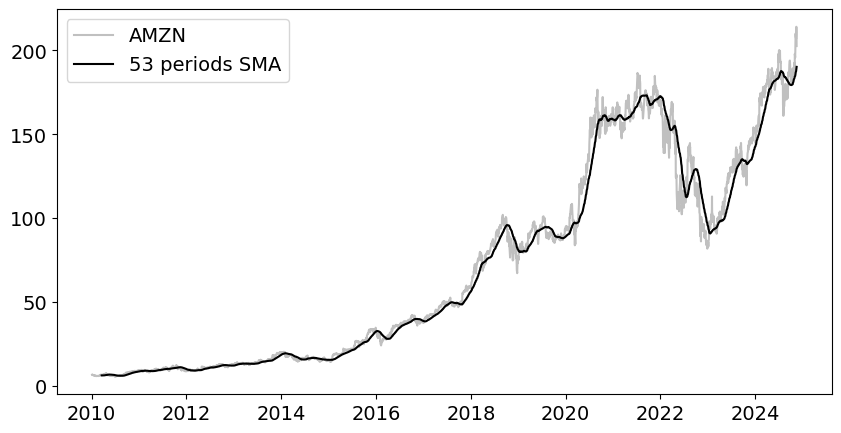

In [216]:
plt.plot(data['Close'],label=name, color='silver')
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma),color='black')
plt.legend()
plt.show()

In [217]:
# data.to_csv('MA292.csv', index=False)

In [218]:
# 2. Choose the best MA for Mid Term 50 days investment
# Mid Term Investment, GLD Ticker name, calculate return after 50 days open window, analyse 10 years data 
# We want to keep the stock in portfolio for 50 days, mid term position trading example

In [219]:
n_forward = 50
name = 'AMZN'
start_date = "2010-01-01"
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')

In [220]:
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [221]:
# Find the most suitable MA, that maximizes the expected return on investment for medium position trader.
# If we buy at 100 USD and after the chosen period the price rises to 105 USD, we have a 5 USD return in 50 days

result = []
train_size = 0.6
for sma_length in range(20,500):
  
  data['SMA'] = data['Close'].rolling(sma_length).mean()
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()
  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  tr_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']
  mean_forward_return_training = tr_returns.mean()
  mean_forward_return_test = test_returns.mean()
  pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]
 
  result.append({
      'sma_length':sma_length,
      'training_forward_return': mean_forward_return_training,
      'test_forward_return': mean_forward_return_test,
      'p-value':pvalue
  })

In [222]:
result.sort(key = lambda x : -x['training_forward_return'])

In [223]:
# ideal MA for 50 days open window is 233
# p-value is higher than 5%, average return in the test set is comparable with the average return in the training set
# no overfitting

result[0]

{'sma_length': 499,
 'training_forward_return': np.float64(0.06502227862469888),
 'test_forward_return': np.float64(0.046961653175927875),
 'p-value': np.float64(0.0001477989631784695)}

In [224]:
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

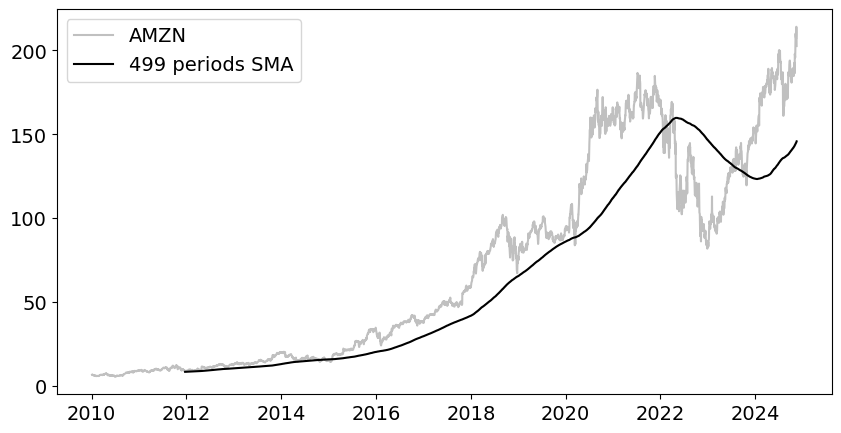

In [225]:
plt.plot(data['Close'],label=name, color='silver')
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma),color='black')
plt.legend()
plt.show()

In [226]:
# data.to_csv('MA233.csv', index=False)

In [227]:
# 3. Calculate Crossover example: MA10 Close over MA50 Close

# load the facebook data, Ticker for facebook has changed from FB to Meta 
name = 'AMZN'
start_date = "2010-01-01"
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')
ticker = yfinance.Ticker(name)
amzn = ticker.history(interval="1d",start=start_date,end=end_date)

In [228]:
# we have 2652 rows in data file
amzn.shape

(3744, 7)

In [229]:
amzn.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.8125,6.8305,6.6570,6.6950,151998000,0.0,0.0
2010-01-05 00:00:00-05:00,6.6715,6.7740,6.5905,6.7345,177038000,0.0,0.0
2010-01-06 00:00:00-05:00,6.7300,6.7365,6.5825,6.6125,143576000,0.0,0.0
2010-01-07 00:00:00-05:00,6.6005,6.6160,6.4400,6.5000,220604000,0.0,0.0
2010-01-08 00:00:00-05:00,6.5280,6.6840,6.4515,6.6760,196610000,0.0,0.0


In [230]:
amzn.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-11 00:00:00-05:00,208.500000,209.649994,205.589996,206.839996,35456000,0.0,0.0
2024-11-12 00:00:00-05:00,208.369995,209.539993,206.009995,208.910004,38942900,0.0,0.0
2024-11-13 00:00:00-05:00,209.399994,215.089996,209.139999,214.100006,46212900,0.0,0.0
2024-11-14 00:00:00-05:00,214.160004,215.899994,210.880005,211.479996,42620300,0.0,0.0
2024-11-15 00:00:00-05:00,206.759995,207.339996,199.610001,202.610001,86418500,0.0,0.0


In [231]:
# Add columns: MA10 (moving average for 10 days), MA50 (moving average for 50 days), MA200, MA233, MA292, ...
# Use dropna to remove not numerical data.

amzn['MA5 hyper'] = amzn['Close'].rolling(5).mean() # hyper fast signal
amzn['MA10 fast'] = amzn['Close'].rolling(10).mean() # fast signal
amzn['MA50 medium'] = amzn['Close'].rolling(50).mean() # medium signal
amzn['MA200 long'] = amzn['Close'].rolling(200).mean() # slow signal
amzn['MA233 long'] = amzn['Close'].rolling(233).mean() # slow signal
amzn['MA292 long'] = amzn['Close'].rolling(292).mean() # slow signal

amzn = amzn.dropna()

amzn.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long
Date,,,,,,,,,,,,,
2011-03-01 00:00:00-05:00,8.6765,8.6980,8.4335,8.4720,116942000,0.0,0.0,8.7440,9.02365,9.08005,7.594250,7.493429,7.246765
2011-03-02 00:00:00-05:00,8.4545,8.6650,8.4175,8.6010,103714000,0.0,0.0,8.6974,8.93860,9.07449,7.605028,7.501034,7.253293
2011-03-03 00:00:00-05:00,8.6855,8.7230,8.6025,8.6395,82764000,0.0,0.0,8.6478,8.86945,9.06399,7.616655,7.508979,7.259817
2011-03-04 00:00:00-05:00,8.6310,8.6375,8.4755,8.5835,98486000,0.0,0.0,8.5921,8.78900,9.05091,7.628425,7.517532,7.266567
2011-03-07 00:00:00-05:00,8.5960,8.6045,8.3120,8.4540,118658000,0.0,0.0,8.5500,8.70190,9.03523,7.640768,7.525599,7.273259


In [29]:
# Golden Cross - If MA10 fast is larger than MA50 slow, the stock price goes up in the next several days and we will buy and hold one share of stock.
# Dead Cross - If MA10 fast is smaller than MA50 slow, the price will probably decrease. 

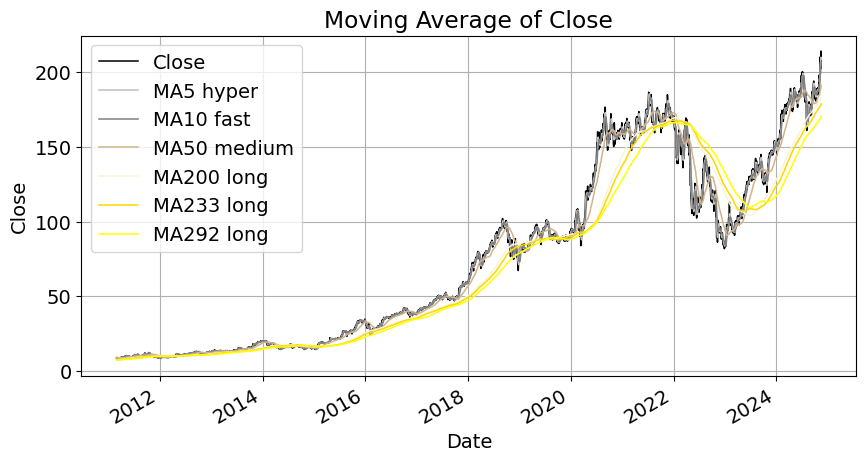

In [232]:
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')                                             

# plot moving averages to see the smooth trendlines, see the multiple crossovers

kwargs= dict (linestyle='solid', color=['black','silver', 'grey','tan', 'beige', 'gold','yellow',], linewidth=1.1)
line_plot = amzn.plot( y = ['Close','MA5 hyper', 'MA10 fast','MA50 medium', 'MA200 long','MA233 long', 'MA292 long'], figsize= (10,5),**kwargs ) 
line_plot.set_title('Moving Average of Close')
line_plot.grid()
line_plot.set_xlabel('Date')
line_plot.set_ylabel('Close');

1, Golden cross - MA10 fast > MA50 medium, Buy signal, purchase stock this day.
0, Dead cross - MA10 fast < MA50 medium, Sell signal, do not purchase stock this day.


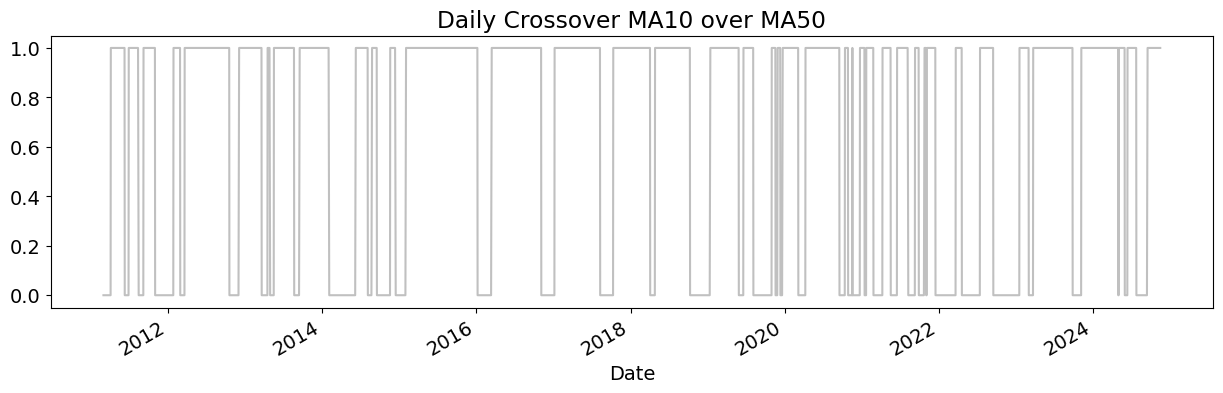

In [233]:
# Add a new column "Crossover", if MA10 fast > MA50 medium, denote as 1 (fast signal to buy stock), otherwise, denote as 0 (do nothing)
# 1 - Golden Cross, fast signal to hold and buy stock, 0 - Dead Cross, fast signal to do nothing

amzn['Crossover'] = [1 if amzn.loc[ei, 'MA10 fast']>amzn.loc[ei, 'MA50 medium'] else 0 for ei in amzn.index]

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')  

amzn['Crossover'].plot(color='silver', figsize= (15,4))
plt.title('Daily Crossover MA10 over MA50')

print('1, Golden cross - MA10 fast > MA50 medium, Buy signal, purchase stock this day.') # Yes
print('0, Dead cross - MA10 fast < MA50 medium, Sell signal, do not purchase stock this day.') # No

In [234]:
amzn.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover
Date,,,,,,,,,,,,,,
2011-03-01 00:00:00-05:00,8.6765,8.6980,8.4335,8.4720,116942000,0.0,0.0,8.7440,9.02365,9.08005,7.594250,7.493429,7.246765,0
2011-03-02 00:00:00-05:00,8.4545,8.6650,8.4175,8.6010,103714000,0.0,0.0,8.6974,8.93860,9.07449,7.605028,7.501034,7.253293,0
2011-03-03 00:00:00-05:00,8.6855,8.7230,8.6025,8.6395,82764000,0.0,0.0,8.6478,8.86945,9.06399,7.616655,7.508979,7.259817,0
2011-03-04 00:00:00-05:00,8.6310,8.6375,8.4755,8.5835,98486000,0.0,0.0,8.5921,8.78900,9.05091,7.628425,7.517532,7.266567,0
2011-03-07 00:00:00-05:00,8.5960,8.6045,8.3120,8.4540,118658000,0.0,0.0,8.5500,8.70190,9.03523,7.640768,7.525599,7.273259,0


If Profit is positive, we should buy stock and we can earn the money.
If Profit is negative, we should not buy stock, not to lose the money.


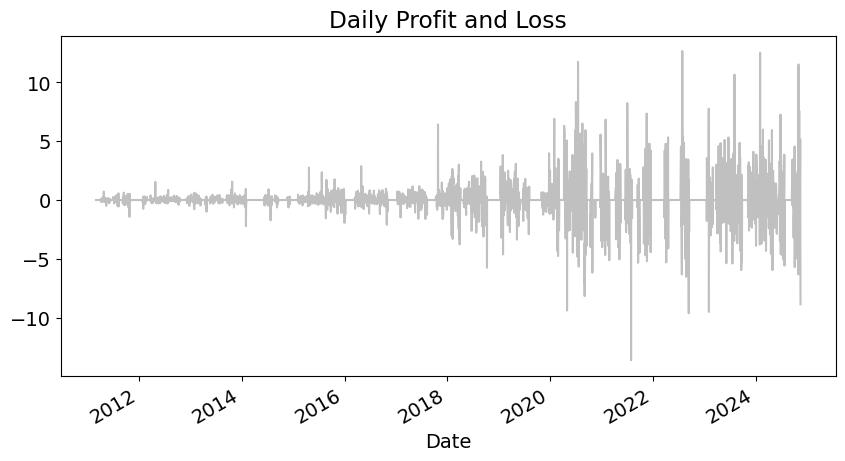

In [235]:
# Add a new column "Profit" using List Comprehension, for any rows in fb, if Crossover=1
# Daily Profit = the close price of Tomorrow - the close price of Today. Otherwise the profit is 0.

amzn['Close1'] = amzn['Close'].shift(-1)

# Positive Profit are days above - We woud have earn the money, if we would purchase the stock.
# Negative Profit are days below - We would lose the money, if we would purchase the stock.

amzn['Profit'] = [amzn.loc[ei, 'Close1'] - amzn.loc[ei, 'Close'] if amzn.loc[ei, 'Crossover']==1 else 0 for ei in amzn.index]

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')  

# Plot a graph to show the Profit and Loss

amzn['Profit'].plot(color='silver')
plt.title('Daily Profit and Loss')

print('If Profit is positive, we should buy stock and we can earn the money.')
print('If Profit is negative, we should not buy stock, not to lose the money.')

In [236]:
# Use .cumsum() to calculate the accumulated wealth over the period
# Create new variable cumultive wealth
# Example strategy MA10 over MA50 is making in day 2022-11-23 USD 95.95, Wealth

amzn['Wealth'] = amzn['Profit'].cumsum()
amzn.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2024-11-11 00:00:00-05:00,208.500000,209.649994,205.589996,206.839996,35456000,0.0,0.0,206.331998,199.532997,188.3978,182.02560,177.776438,169.297500,1,208.910004,2.070007,123.878514
2024-11-12 00:00:00-05:00,208.369995,209.539993,206.009995,208.910004,38942900,0.0,0.0,208.213998,201.340997,189.0510,182.26385,178.040343,169.532158,1,214.100006,5.190002,129.068517
2024-11-13 00:00:00-05:00,209.399994,215.089996,209.139999,214.100006,46212900,0.0,0.0,209.616000,203.477998,189.8664,182.53935,178.333090,169.785993,1,211.479996,-2.620010,126.448506
2024-11-14 00:00:00-05:00,214.160004,215.899994,210.880005,211.479996,42620300,0.0,0.0,209.901999,205.985999,190.5382,182.82075,178.607768,170.038904,1,202.610001,-8.869995,117.578511
2024-11-15 00:00:00-05:00,206.759995,207.339996,199.610001,202.610001,86418500,0.0,0.0,208.788000,206.453999,191.1626,183.03740,178.838541,170.269452,1,NaN,NaN,NaN


In [237]:
amzn.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2024-11-13 00:00:00-05:00,209.399994,215.089996,209.139999,214.100006,46212900,0.0,0.0,209.616000,203.477998,189.8664,182.53935,178.333090,169.785993,1,211.479996,-2.620010,126.448506
2024-11-14 00:00:00-05:00,214.160004,215.899994,210.880005,211.479996,42620300,0.0,0.0,209.901999,205.985999,190.5382,182.82075,178.607768,170.038904,1,202.610001,-8.869995,117.578511
2024-11-15 00:00:00-05:00,206.759995,207.339996,199.610001,202.610001,86418500,0.0,0.0,208.788000,206.453999,191.1626,183.03740,178.838541,170.269452,1,NaN,NaN,NaN


Total money you win is 117.57851123809814
Total money you spent is 8.472000122070312


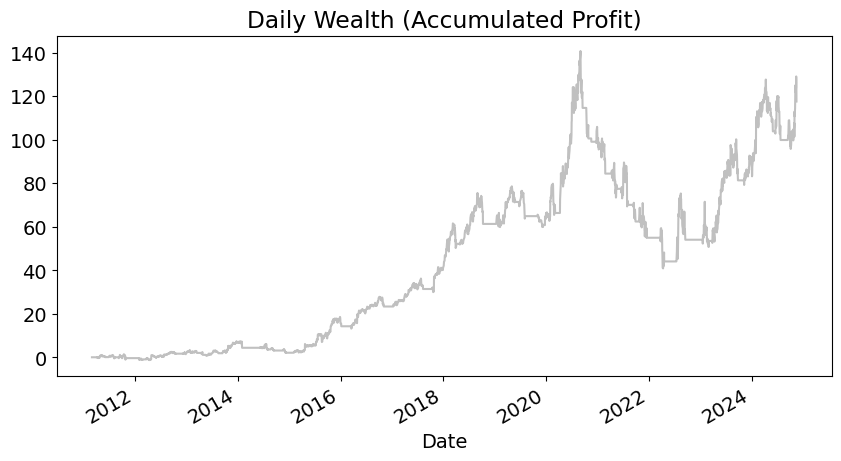

In [238]:
# Plot the wealth to show the growth of profit over the period

start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime("today").strftime('%Y-%m-%d')                                                  


amzn['Wealth'].plot(color='silver')
plt.title('Daily Wealth (Accumulated Profit)')

print('Total money you win is {}'.format(amzn.loc[amzn.index[-2], 'Wealth'])) # wealth at the end of considered time period
print('Total money you spent is {}'.format(amzn.loc[amzn.index[0], 'Close'])) # initial investment is the stock price on the first day, Close

In [239]:
amzn.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA5 hyper,MA10 fast,MA50 medium,MA200 long,MA233 long,MA292 long,Crossover,Close1,Profit,Wealth
Date,,,,,,,,,,,,,,,,,
2011-03-01 00:00:00-05:00,8.6765,8.6980,8.4335,8.4720,116942000,0.0,0.0,8.7440,9.02365,9.08005,7.594250,7.493429,7.246765,0,8.6010,0.0,0.0
2011-03-02 00:00:00-05:00,8.4545,8.6650,8.4175,8.6010,103714000,0.0,0.0,8.6974,8.93860,9.07449,7.605028,7.501034,7.253293,0,8.6395,0.0,0.0
2011-03-03 00:00:00-05:00,8.6855,8.7230,8.6025,8.6395,82764000,0.0,0.0,8.6478,8.86945,9.06399,7.616655,7.508979,7.259817,0,8.5835,0.0,0.0
2011-03-04 00:00:00-05:00,8.6310,8.6375,8.4755,8.5835,98486000,0.0,0.0,8.5921,8.78900,9.05091,7.628425,7.517532,7.266567,0,8.4540,0.0,0.0
2011-03-07 00:00:00-05:00,8.5960,8.6045,8.3120,8.4540,118658000,0.0,0.0,8.5500,8.70190,9.03523,7.640768,7.525599,7.273259,0,8.3445,0.0,0.0


In [240]:
amzn = amzn.drop('Stock Splits', axis=1)

/var/folders/0y/ktfwtf896bvb5xzg3ghz6t700000gn/T/ipykernel_34890/2051346079.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  amzn.plot(ax=a,subplots = True, figsize = (10, 10), rot=60,sharex=True, sharey=True,


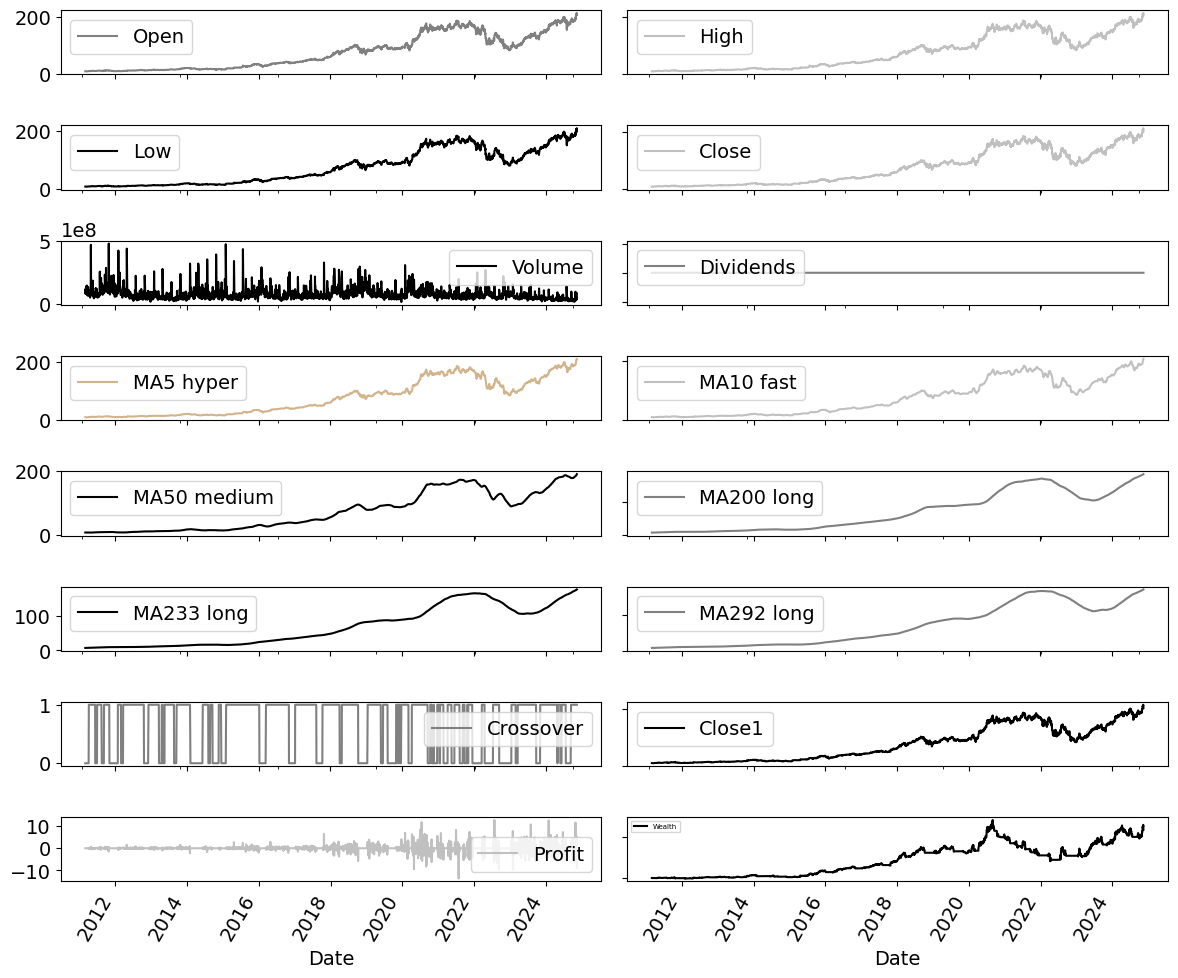

In [241]:
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime("today").strftime('%Y-%m-%d') 

fig, a = plt.subplots(8, 2, figsize=(12, 10), tight_layout=True)
amzn.plot(ax=a,subplots = True, figsize = (10, 10), rot=60,sharex=True, sharey=True,
                color={"Open": "grey", "High": "silver","Low": "black", "Close": "silver",
                       "Volume": "black","Dividends": "grey", "MA5 hyper": "tan","MA10 fast": "silver", 
                       "MA50 medium": "black","MA200 long": "grey","MA233 long": "black","MA292 long": "grey",
                       "Crossover": "grey", "Close1": "black", "Profit": "silver", "Wealth": "black"});
plt.legend(loc = 'best', fontsize=5)
plt.show()

In [242]:
# amzn.to_csv('FB_MA.csv', index=False)